In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [10]:
df = df.loc[df.date >= '2021-01-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

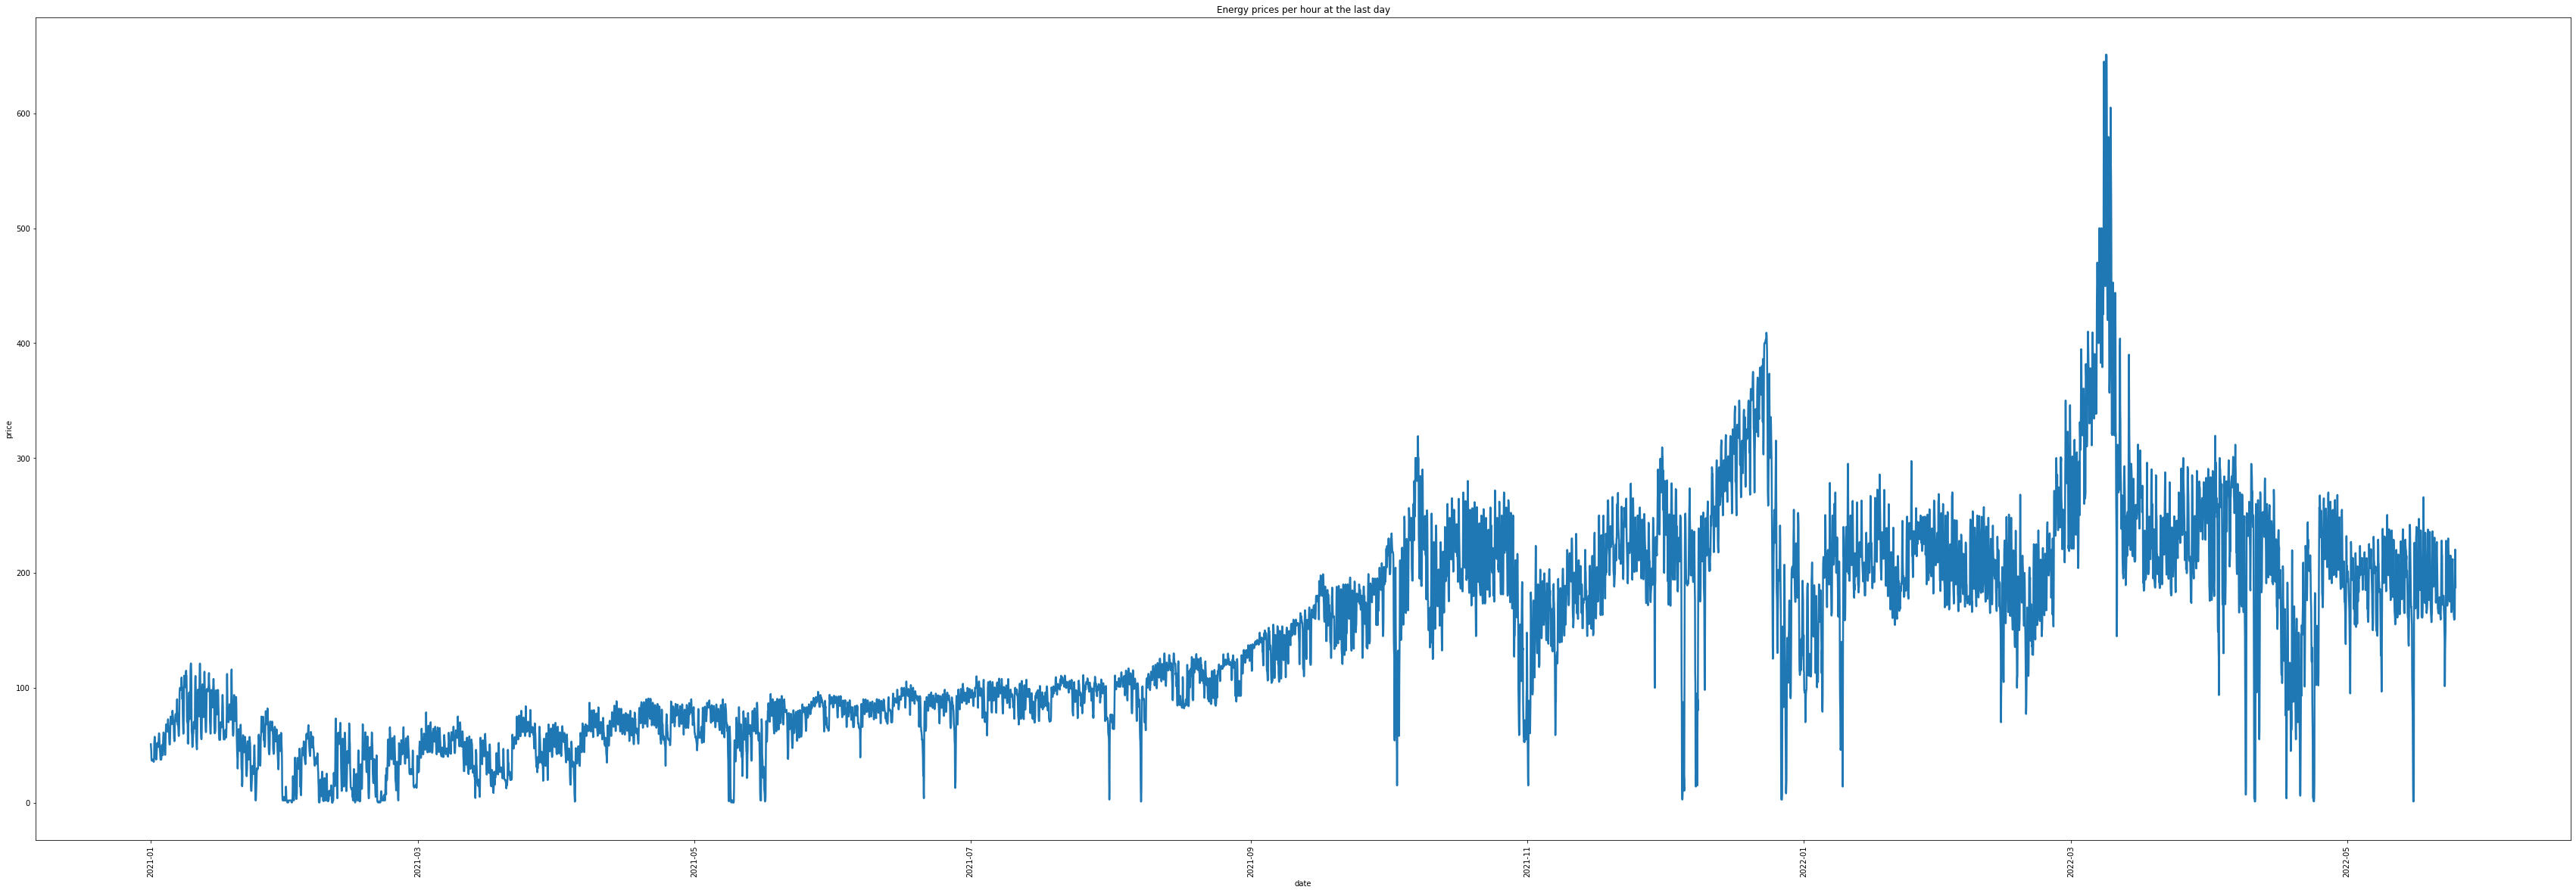

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [15]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana de 1 dia (le damos 1 semana)
w_size = 24 * 7
#Número de entradas
n_inputs = len(df.columns)
n_outputs = 24 

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple_input_output(df, w_size, n_outputs):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir la ventana varia. Incrementa según el número de salidas
    for i in range(0, len(df_as_np) - w_size - n_outputs, n_outputs):
        row = [r for r in df_as_np[i:(i + w_size)]]
        x.append(row)
        
        #Solo queremos el precio
        label = []
        for j in range((i + w_size), (i + w_size + n_outputs)):
            label.append(df_as_np[j][0])
        
        y.append(label)
    
    return np.array(x), np.array(y)

In [17]:
x, y = df_to_x_y_multiple_input_output(df, w_size, n_outputs)
x.shape, y.shape

((501, 168, 7), (501, 24))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((350, 168, 7), (350, 24), (101, 168, 7), (101, 24), (50, 168, 7), (50, 24))

In [20]:
x_mean = np.mean(x[:, :, 0])
x_std = np.std(x[:, :, 0])
print(x_mean)
print(x_std)

141.22036439026706
87.1419131860331


In [21]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:,:] = (df[:,:] - x_mean) / x_std
    return df

In [22]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)

In [23]:
print(x_train_norm[0][0])

[-1.03681869 -0.25881905  0.96592583 -0.78183148  0.62348981 -0.89516667
  0.44573156]


In [24]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(128))
    model.add(tf.keras.layers.Dense(64, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(138, return_sequences = True))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [30]:
def build_model_lstm_unrestricted():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [31]:
def build_model_lstm_dropout():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [32]:
def build_model_lstm_go_bwd():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, go_backwards = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [33]:
def build_model_lstm_bidirectional():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [34]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()
model_lstm_unrestricted = build_model_lstm_unrestricted()
model_lstm_dropout = build_model_lstm_dropout()
model_lstm_go_bwd = build_model_lstm_go_bwd()
model_lstm_bi = build_model_lstm_bidirectional()

2022-06-14 12:33:55.397072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 12:33:56.413262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13279 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-14 12:33:56.414478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29097 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [36]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500


2022-06-14 12:33:59.878944: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


11/11 [==============================] - 3s 59ms/step - loss: 0.8271 - mae: 0.7926 - mse: 0.8271 - val_loss: 0.6538 - val_mae: 0.6965 - val_mse: 0.6538
Epoch 2/500
11/11 [==============================] - 0s 26ms/step - loss: 0.6219 - mae: 0.6536 - mse: 0.6219 - val_loss: 0.5489 - val_mae: 0.6018 - val_mse: 0.5489
Epoch 3/500
11/11 [==============================] - 0s 27ms/step - loss: 0.4115 - mae: 0.4989 - mse: 0.4115 - val_loss: 0.4599 - val_mae: 0.5188 - val_mse: 0.4599
Epoch 4/500
11/11 [==============================] - 0s 26ms/step - loss: 0.2897 - mae: 0.4008 - mse: 0.2897 - val_loss: 0.4413 - val_mae: 0.4949 - val_mse: 0.4413
Epoch 5/500
11/11 [==============================] - 0s 26ms/step - loss: 0.1555 - mae: 0.2868 - mse: 0.1555 - val_loss: 0.3681 - val_mae: 0.4296 - val_mse: 0.3681
Epoch 6/500
11/11 [==============================] - 0s 26ms/step - loss: 0.1760 - mae: 0.3149 - mse: 0.1760 - val_loss: 0.4003 - val_mae: 0.4379 - val_mse: 0.4003
Epoch 7/500
11/11 [=========

In [37]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 1s 24ms/step - loss: 0.7894 - mae: 0.6631 - mse: 0.7894 - val_loss: 0.7042 - val_mae: 0.7001 - val_mse: 0.7042
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 0.8075 - mae: 0.7693 - mse: 0.8075 - val_loss: 0.6549 - val_mae: 0.6710 - val_mse: 0.6549
Epoch 3/500
11/11 [==============================] - 0s 10ms/step - loss: 0.8129 - mae: 0.7404 - mse: 0.8129 - val_loss: 0.6823 - val_mae: 0.6979 - val_mse: 0.6823
Epoch 4/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7454 - mae: 0.7101 - mse: 0.7454 - val_loss: 0.6994 - val_mae: 0.7158 - val_mse: 0.6994
Epoch 5/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7388 - mae: 0.6521 - mse: 0.7388 - val_loss: 0.7500 - val_mae: 0.7336 - val_mse: 0.7500
Epoch 6/500
11/11 [==============================] - 0s 10ms/step - loss: 0.6993 - mae: 0.6471 - mse: 0.6993 - val_loss: 0.7036 - val_mae: 0.7233 - val_mse: 0.7036
Epoch 7/500
11/1

In [38]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 0s 18ms/step - loss: 0.8618 - mae: 0.7457 - mse: 0.8618 - val_loss: 0.6797 - val_mae: 0.7030 - val_mse: 0.6797
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 0.8420 - mae: 0.8009 - mse: 0.8420 - val_loss: 0.7086 - val_mae: 0.7358 - val_mse: 0.7086
Epoch 3/500
11/11 [==============================] - 0s 10ms/step - loss: 0.8186 - mae: 0.7846 - mse: 0.8186 - val_loss: 0.7065 - val_mae: 0.7344 - val_mse: 0.7065
Epoch 4/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7819 - mae: 0.7342 - mse: 0.7819 - val_loss: 0.7096 - val_mae: 0.7362 - val_mse: 0.7096
Epoch 5/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7369 - mae: 0.6876 - mse: 0.7369 - val_loss: 0.7027 - val_mae: 0.7298 - val_mse: 0.7027
Epoch 6/500
11/11 [==============================] - 0s 10ms/step - loss: 0.6939 - mae: 0.6713 - mse: 0.6939 - val_loss: 0.7071 - val_mae: 0.7335 - val_mse: 0.7071
Epoch 7/500
11/1

In [39]:
history_gru = model_gru.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 2s 51ms/step - loss: 0.8527 - mae: 0.8036 - mse: 0.8527 - val_loss: 0.7313 - val_mae: 0.7497 - val_mse: 0.7313
Epoch 2/500
11/11 [==============================] - 0s 24ms/step - loss: 0.8108 - mae: 0.7794 - mse: 0.8108 - val_loss: 0.7157 - val_mae: 0.7399 - val_mse: 0.7157
Epoch 3/500
11/11 [==============================] - 0s 24ms/step - loss: 0.7834 - mae: 0.7584 - mse: 0.7834 - val_loss: 0.7096 - val_mae: 0.7301 - val_mse: 0.7096
Epoch 4/500
11/11 [==============================] - 0s 24ms/step - loss: 0.7562 - mae: 0.7330 - mse: 0.7562 - val_loss: 0.7112 - val_mae: 0.7232 - val_mse: 0.7112
Epoch 5/500
11/11 [==============================] - 0s 23ms/step - loss: 0.7258 - mae: 0.7005 - mse: 0.7258 - val_loss: 0.7127 - val_mae: 0.7152 - val_mse: 0.7127
Epoch 6/500
11/11 [==============================] - 0s 24ms/step - loss: 0.6938 - mae: 0.6681 - mse: 0.6938 - val_loss: 0.7138 - val_mae: 0.7066 - val_mse: 0.7138
Epoch 7/500
11/1

In [40]:
history_lstm_unrestricted = model_lstm_unrestricted.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 3s 86ms/step - loss: 0.4177 - mae: 0.5388 - mse: 0.4177 - val_loss: 0.3992 - val_mae: 0.4525 - val_mse: 0.3992
Epoch 2/500
11/11 [==============================] - 0s 35ms/step - loss: 0.3796 - mae: 0.4280 - mse: 0.3796 - val_loss: 0.6029 - val_mae: 0.5821 - val_mse: 0.6029
Epoch 3/500
11/11 [==============================] - 0s 35ms/step - loss: 0.3401 - mae: 0.3817 - mse: 0.3401 - val_loss: 0.5436 - val_mae: 0.6320 - val_mse: 0.5436
Epoch 4/500
11/11 [==============================] - 0s 36ms/step - loss: 0.1332 - mae: 0.2637 - mse: 0.1332 - val_loss: 0.4295 - val_mae: 0.4617 - val_mse: 0.4295
Epoch 5/500
11/11 [==============================] - 0s 36ms/step - loss: 0.1570 - mae: 0.2809 - mse: 0.1570 - val_loss: 0.3453 - val_mae: 0.4180 - val_mse: 0.3453
Epoch 6/500
11/11 [==============================] - 0s 36ms/step - loss: 0.2012 - mae: 0.3143 - mse: 0.2012 - val_loss: 0.5254 - val_mae: 0.5282 - val_mse: 0.5254
Epoch 7/500
11/1

In [41]:
history_lstm_dropout = model_lstm_dropout.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 10s 715ms/step - loss: 0.4433 - mae: 0.5463 - mse: 0.4433 - val_loss: 0.4058 - val_mae: 0.4751 - val_mse: 0.4058
Epoch 2/500
11/11 [==============================] - 7s 653ms/step - loss: 0.3389 - mae: 0.3968 - mse: 0.3389 - val_loss: 0.6387 - val_mae: 0.6027 - val_mse: 0.6387
Epoch 3/500
11/11 [==============================] - 7s 671ms/step - loss: 0.2790 - mae: 0.3588 - mse: 0.2790 - val_loss: 0.5250 - val_mae: 0.6209 - val_mse: 0.5250
Epoch 4/500
11/11 [==============================] - 7s 658ms/step - loss: 0.1711 - mae: 0.3079 - mse: 0.1711 - val_loss: 0.4053 - val_mae: 0.4480 - val_mse: 0.4053
Epoch 5/500
11/11 [==============================] - 7s 653ms/step - loss: 0.1647 - mae: 0.2891 - mse: 0.1647 - val_loss: 0.3425 - val_mae: 0.4101 - val_mse: 0.3425
Epoch 6/500
11/11 [==============================] - 7s 664ms/step - loss: 0.2133 - mae: 0.3358 - mse: 0.2133 - val_loss: 0.5152 - val_mae: 0.5207 - val_mse: 0.5152
Epoch 7/5

In [42]:
history_lstm_go_bwd = model_lstm_go_bwd.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 3s 90ms/step - loss: 0.3746 - mae: 0.5017 - mse: 0.3746 - val_loss: 0.3859 - val_mae: 0.4431 - val_mse: 0.3859
Epoch 2/500
11/11 [==============================] - 0s 36ms/step - loss: 0.3754 - mae: 0.4378 - mse: 0.3754 - val_loss: 0.5193 - val_mae: 0.5217 - val_mse: 0.5193
Epoch 3/500
11/11 [==============================] - 0s 36ms/step - loss: 0.4080 - mae: 0.4161 - mse: 0.4080 - val_loss: 0.6816 - val_mae: 0.7357 - val_mse: 0.6816
Epoch 4/500
11/11 [==============================] - 0s 38ms/step - loss: 0.1648 - mae: 0.3089 - mse: 0.1648 - val_loss: 0.3839 - val_mae: 0.4410 - val_mse: 0.3839
Epoch 5/500
11/11 [==============================] - 0s 37ms/step - loss: 0.1249 - mae: 0.2453 - mse: 0.1249 - val_loss: 0.3488 - val_mae: 0.4088 - val_mse: 0.3488
Epoch 6/500
11/11 [==============================] - 0s 36ms/step - loss: 0.1786 - mae: 0.3014 - mse: 0.1786 - val_loss: 0.4622 - val_mae: 0.4814 - val_mse: 0.4622
Epoch 7/500
11/1

In [43]:
history_lstm_bi = model_lstm_bi.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
11/11 [==============================] - 5s 158ms/step - loss: 0.4172 - mae: 0.4982 - mse: 0.4172 - val_loss: 0.3734 - val_mae: 0.4218 - val_mse: 0.3734
Epoch 2/500
11/11 [==============================] - 1s 64ms/step - loss: 0.5344 - mae: 0.5593 - mse: 0.5344 - val_loss: 0.3659 - val_mae: 0.4409 - val_mse: 0.3659
Epoch 3/500
11/11 [==============================] - 1s 64ms/step - loss: 0.9322 - mae: 0.7031 - mse: 0.9322 - val_loss: 0.6859 - val_mae: 0.7198 - val_mse: 0.6859
Epoch 4/500
11/11 [==============================] - 1s 64ms/step - loss: 0.1360 - mae: 0.2467 - mse: 0.1360 - val_loss: 0.3795 - val_mae: 0.4287 - val_mse: 0.3795
Epoch 5/500
11/11 [==============================] - 1s 64ms/step - loss: 0.1481 - mae: 0.2921 - mse: 0.1481 - val_loss: 0.3844 - val_mae: 0.4429 - val_mse: 0.3844
Epoch 6/500
11/11 [==============================] - 1s 64ms/step - loss: 0.1436 - mae: 0.2791 - mse: 0.1436 - val_loss: 0.3592 - val_mae: 0.4202 - val_mse: 0.3592
Epoch 7/500
11/

In [44]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

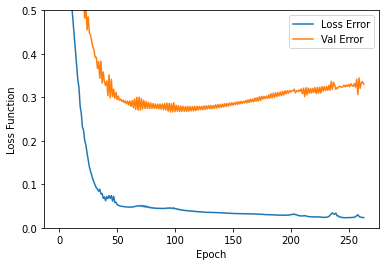

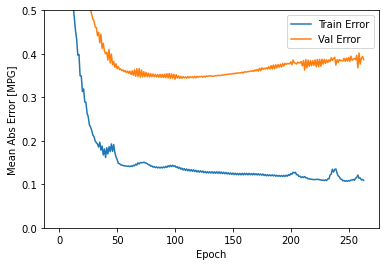

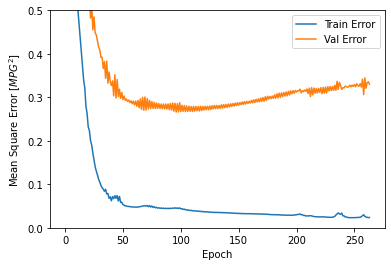

In [45]:
plot_history(history_gru, 0, 0.5, 0.5, 0.5)

In [60]:
def history_to_hist(history, string):
    hist = pd.DataFrame(history.history)
    temp = pd.to_numeric(hist[string], errors='coerce')
    res = []
    for i in range(temp.size):
        res.append(temp[i])
    return res

In [62]:
hist_lstm_loss = np.mean(history_to_hist(history_lstm, "loss"))
hist_cnn_loss = np.mean(history_to_hist(history_cnn, "loss"))
hist_gru_loss = np.mean(history_to_hist(history_gru, "loss"))
#hist_lstm_ret_seq_loss = np.mean(history_to_hist(history_lstm_ret_seq, "loss"))
hist_cnn_relu_loss = np.mean(history_to_hist(history_cnn_relu, "loss"))
hist_lstm_unrestricted_loss = np.mean(history_to_hist(history_lstm_unrestricted, "loss"))
hist_lstm_dropout_loss = np.mean(history_to_hist(history_lstm_dropout, "loss"))
hist_lstm_go_bwd_loss = np.mean(history_to_hist(history_lstm_go_bwd, "loss"))
hist_lstm_bi_loss = np.mean(history_to_hist(history_lstm_bi, "loss"))

In [64]:
hist_lstm_loss_val = np.mean(history_to_hist(history_lstm, "val_loss"))
hist_cnn_loss_val = np.mean(history_to_hist(history_cnn, "val_loss"))
hist_gru_loss_val = np.mean(history_to_hist(history_gru, "val_loss"))
#hist_lstm_ret_seq_loss_val = np.mean(history_to_hist(history_lstm_ret_seq, "val_loss"))
hist_cnn_relu_loss_val = np.mean(history_to_hist(history_cnn_relu, "val_loss"))
hist_lstm_unrestricted_loss_val = np.mean(history_to_hist(history_lstm_unrestricted, "val_loss"))
hist_lstm_dropout_loss_val = np.mean(history_to_hist(history_lstm_dropout, "val_loss"))
hist_lstm_go_bwd_loss_val = np.mean(history_to_hist(history_lstm_go_bwd, "val_loss"))
hist_lstm_bi_loss_val = np.mean(history_to_hist(history_lstm_bi, "val_loss"))

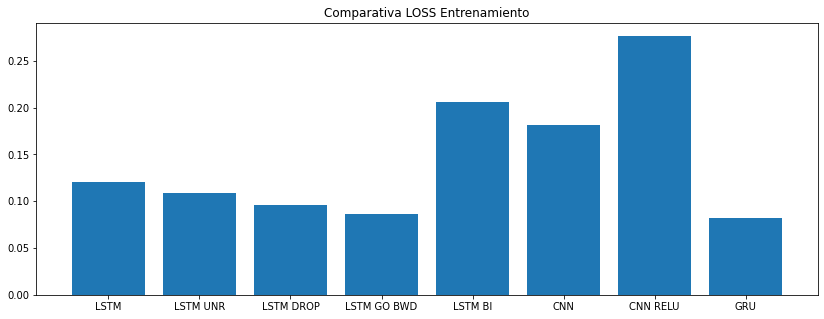

In [67]:
x_axis = ["LSTM", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [hist_lstm_loss, hist_lstm_unrestricted_loss, hist_lstm_dropout_loss, hist_lstm_go_bwd_loss, hist_lstm_bi_loss, hist_cnn_loss, hist_cnn_relu_loss, hist_gru_loss]
plt.figure(figsize=(14,5))
plt.title("Comparativa LOSS Entrenamiento")
plt.bar(x_axis, y_axis)
plt.show()

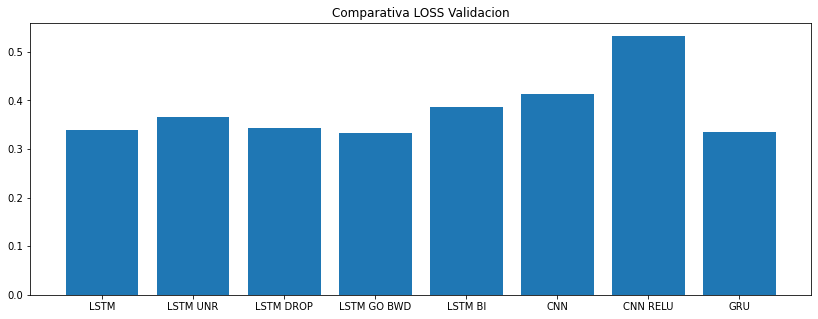

In [74]:
x_axis = ["LSTM", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [hist_lstm_loss_val, hist_lstm_unrestricted_loss_val, hist_lstm_dropout_loss_val, hist_lstm_go_bwd_loss_val, hist_lstm_bi_loss_val, hist_cnn_loss_val, hist_cnn_relu_loss_val, hist_gru_loss_val]
plt.figure(figsize=(14,5))
plt.title("Comparativa LOSS Validacion")
plt.bar(x_axis, y_axis)
plt.show()

In [46]:
y_pred_lstm = model_lstm.predict(x_test_norm)
y_pred_cnn = model_cnn.predict(x_test_norm)
y_pred_gru = model_gru.predict(x_test_norm)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)
y_pred_lstm_unrestricted = model_lstm_unrestricted.predict(x_test_norm)
y_pred_lstm_dropout = model_lstm_dropout.predict(x_test_norm)
y_pred_lstm_go_bwd = model_lstm_go_bwd.predict(x_test_norm)
y_pred_lstm_bi = model_lstm_bi.predict(x_test_norm)

In [47]:
def inverse_standarize_input(arr):
    arr = (arr * x_std) + x_mean
    return arr

In [48]:
y_pred_lstm = inverse_standarize_input(y_pred_lstm)
y_pred_cnn = inverse_standarize_input(y_pred_cnn)
y_pred_gru = inverse_standarize_input(y_pred_gru)
y_pred_lstm_ret_seq = inverse_standarize_input(y_pred_lstm_ret_seq)
y_pred_cnn_relu = inverse_standarize_input(y_pred_cnn_relu)
y_test = inverse_standarize_input(y_test_norm)
y_pred_lstm_unrestricted = inverse_standarize_input(y_pred_lstm_unrestricted)
y_pred_lstm_bi = inverse_standarize_input(y_pred_lstm_bi)
y_pred_lstm_dropout = inverse_standarize_input(y_pred_lstm_dropout)
y_pred_lstm_go_bwd = inverse_standarize_input(y_pred_lstm_go_bwd)

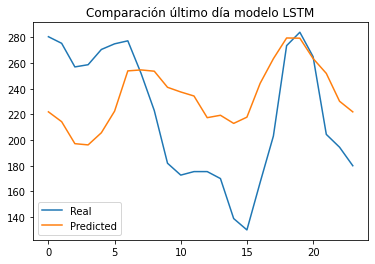

In [49]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

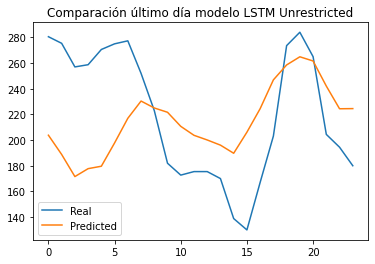

In [50]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_unrestricted[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM Unrestricted")
plt.legend()

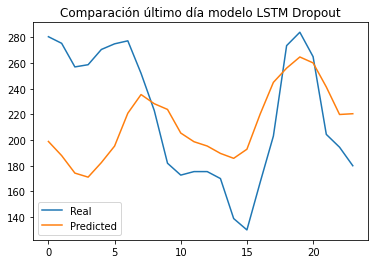

In [51]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_dropout[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM Dropout")
plt.legend()

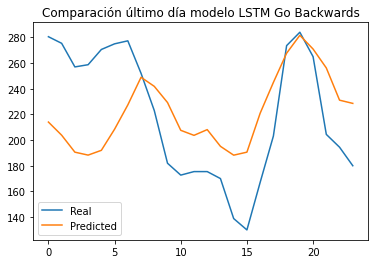

In [52]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_go_bwd[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM Go Backwards")
plt.legend()

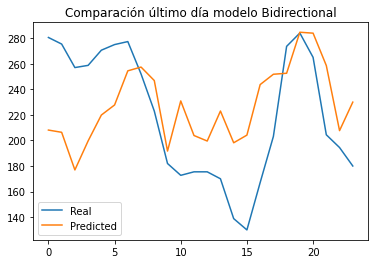

In [53]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_bi[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo Bidirectional")
plt.legend()

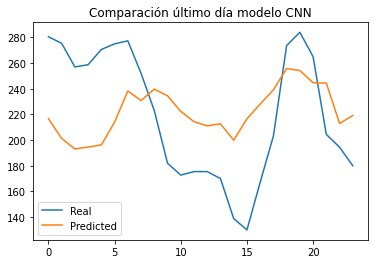

In [54]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_cnn[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

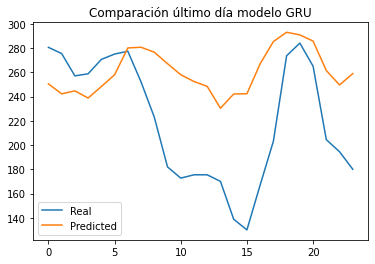

In [55]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_gru[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

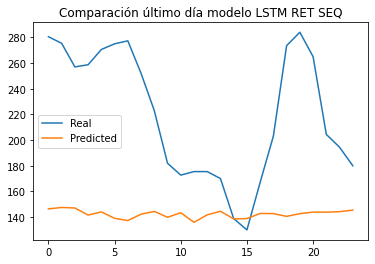

In [56]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_ret_seq[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

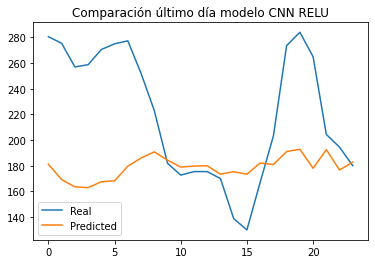

In [57]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_cnn_relu[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [58]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)
rmse_lstm_unrestricted = np.sqrt(mean_squared_error(y_test, y_pred_lstm_unrestricted))
mae_lstm_unrestricted = mean_absolute_error(y_test, y_pred_lstm_unrestricted)
rmse_lstm_dropout = np.sqrt(mean_squared_error(y_test, y_pred_lstm_dropout))
mae_lstm_dropout = mean_absolute_error(y_test, y_pred_lstm_dropout)
rmse_lstm_go_bwd = np.sqrt(mean_squared_error(y_test, y_pred_lstm_go_bwd))
mae_lstm_go_bwd = mean_absolute_error(y_test, y_pred_lstm_go_bwd)
rmse_lstm_bi = np.sqrt(mean_squared_error(y_test, y_pred_lstm_bi))
mae_lstm_bi = mean_absolute_error(y_test, y_pred_lstm_bi)

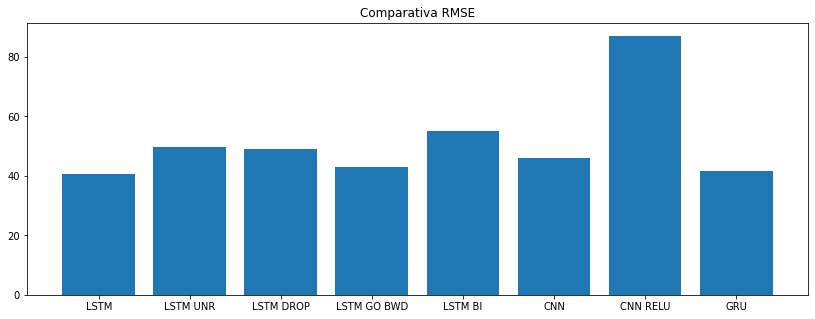

In [72]:
x_axis = ["LSTM", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [rmse_lstm, rmse_lstm_unrestricted, rmse_lstm_dropout, rmse_lstm_go_bwd, rmse_lstm_bi, rmse_cnn, rmse_cnn_relu, rmse_gru]
plt.figure(figsize=(14,5))
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

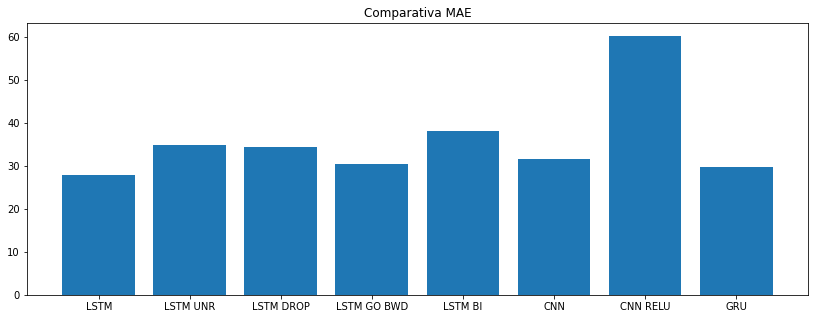

In [73]:
x_axis = ["LSTM", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [mae_lstm, mae_lstm_unrestricted, mae_lstm_dropout, mae_lstm_go_bwd, mae_lstm_bi, mae_cnn, mae_cnn_relu, mae_gru]
plt.figure(figsize=(14,5))
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [ ]:
model_lstm_go_bwd.save("modelday")